In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F


In [2]:
try:
    spark.stop()
except:
    pass

spark = SparkSession.builder.appName("RobosPeru").getOrCreate()
spark.version


'3.5.0'

In [5]:
df = spark.read.csv("./data/robos.csv", header=True, inferSchema=True)

df.show(5)

+----+---+--------------+----------+----------+------------+--------------------+--------+
|ANIO|MES|DPTO_HECHO_NEW|PROV_HECHO|DIST_HECHO|UBIGEO_HECHO|       P_MODALIDADES|cantidad|
+----+---+--------------+----------+----------+------------+--------------------+--------+
|2018|  1|      AMAZONAS|     BAGUA|  ARAMANGO|       10202|               Otros|       6|
|2018|  1|      AMAZONAS|     BAGUA|  ARAMANGO|       10202|Violencia contra ...|       1|
|2018|  1|      AMAZONAS|     BAGUA|     BAGUA|       10201|              Estafa|       2|
|2018|  1|      AMAZONAS|     BAGUA|     BAGUA|       10201|               Hurto|      25|
|2018|  1|      AMAZONAS|     BAGUA|     BAGUA|       10201|               Otros|      64|
+----+---+--------------+----------+----------+------------+--------------------+--------+
only showing top 5 rows



In [6]:
df.printSchema()


root
 |-- ANIO: integer (nullable = true)
 |-- MES: integer (nullable = true)
 |-- DPTO_HECHO_NEW: string (nullable = true)
 |-- PROV_HECHO: string (nullable = true)
 |-- DIST_HECHO: string (nullable = true)
 |-- UBIGEO_HECHO: integer (nullable = true)
 |-- P_MODALIDADES: string (nullable = true)
 |-- cantidad: integer (nullable = true)



In [8]:
#Consulta de riesgo por distrito
riesgo = df.groupBy("UBIGEO_HECHO", "DIST_HECHO") \
           .agg(F.sum("cantidad").alias("total_robos"))

max_total = riesgo.agg(F.max("total_robos")).collect()[0][0]

riesgo = riesgo.withColumn("nivel_riesgo", 
    F.when(riesgo.total_robos < 0.33*max_total, "Bajo")
     .when(riesgo.total_robos < 0.66*max_total, "Medio")
     .otherwise("Alto")
)

riesgo.show(10)

+------------+-------------+-----------+------------+
|UBIGEO_HECHO|   DIST_HECHO|total_robos|nivel_riesgo|
+------------+-------------+-----------+------------+
|       60801|         JAEN|      28968|        Bajo|
|      220802|       AWAJUN|        602|        Bajo|
|      220904|      CHAZUTA|        536|        Bajo|
|      100321|      SHUNQUI|         49|        Bajo|
|       80504|       LANGUI|        116|        Bajo|
|       80207|    SANGARARA|        101|        Bajo|
|       10101|  CHACHAPOYAS|      11509|        Bajo|
|      120134|       SICAYA|       2293|        Bajo|
|      200606| MIGUEL CHECA|       1029|        Bajo|
|      150714|RICARDO PALMA|       2727|        Bajo|
+------------+-------------+-----------+------------+
only showing top 10 rows



In [9]:
#Modalidades frecuentes
modalidades = df.groupBy("UBIGEO_HECHO", "P_MODALIDADES") \
                .agg(F.sum("cantidad").alias("total")) \
                .orderBy(F.desc("total"))

modalidades.show(10)

+------------+--------------------+-----+
|UBIGEO_HECHO|       P_MODALIDADES|total|
+------------+--------------------+-----+
|      150101|               Otros|73242|
|      150132|               Otros|72478|
|      150132|Violencia contra ...|65665|
|       70101|               Otros|61936|
|      150101|               Hurto|56269|
|      140101|               Hurto|47965|
|      150132|               Hurto|47591|
|      140101|               Otros|45559|
|      150101|Violencia contra ...|42996|
|       70101|Violencia contra ...|42574|
+------------+--------------------+-----+
only showing top 10 rows



In [15]:
#Zonas más reportadas (Mapa de calor)
zonas = df.groupBy("UBIGEO_HECHO", "DIST_HECHO") \
          .agg(F.sum("cantidad").alias("total")) \
          .orderBy(F.desc("total"))



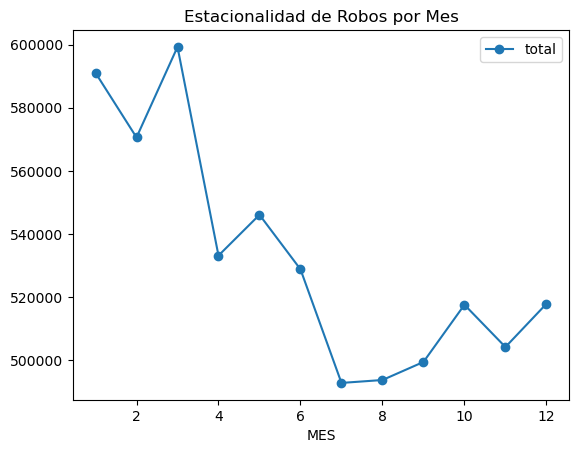

In [16]:
#Predicción temporal (estacionalidad)
import matplotlib.pyplot as plt
temporal = df.groupBy("MES") \
             .agg(F.sum("cantidad").alias("total")) \
             .orderBy("MES")

temporal_pd = temporal.toPandas()

temporal_pd.plot(x="MES", y="total", kind="line", marker="o")
plt.title("Estacionalidad de Robos por Mes")
plt.show()

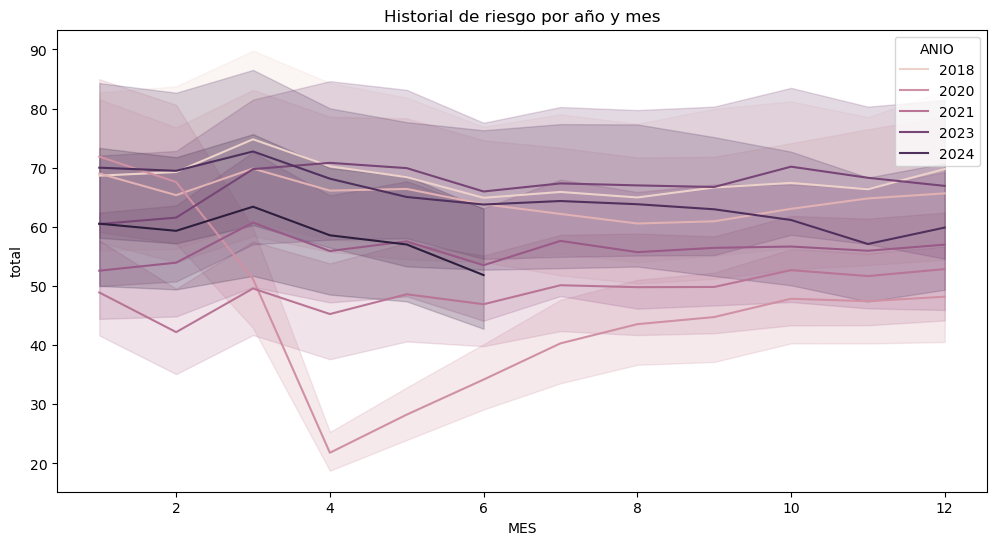

In [17]:
#Historial de riesgo
historial = df.groupBy("ANIO", "MES", "UBIGEO_HECHO") \
              .agg(F.sum("cantidad").alias("total")) \
              .orderBy("ANIO", "MES")

historial_pd = historial.toPandas()

import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=historial_pd, x="MES", y="total", hue="ANIO")
plt.title("Historial de riesgo por año y mes")
plt.show()
